In [ ]:
# install transformers
#!pip install transformers
!pip install accelerate>=0.21.0
!pip install transformers --upgrade
!pip install datasets
!pip install torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00


In [ ]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Financial sentiment analysis using Transformers/financial_data.csv')

In [ ]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


<Axes: >

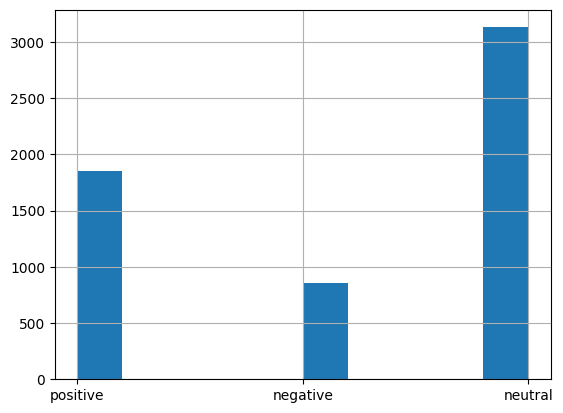

In [ ]:
df['Sentiment'].hist()

In [ ]:
target_map = { 'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['Sentiment'].map(target_map)

In [ ]:
df.head()

,Sentence,Sentiment,target
0,The GeoSolutions technology will leverage Bene...,positive,1
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,0
2,"For the last quarter of 2010 , Componenta 's n...",positive,1
3,According to the Finnish-Russian Chamber of Co...,neutral,2
4,The Swedish buyout firm has sold its remaining...,neutral,2


In [ ]:
df1 = df[['Sentence','target']]
df1.columns = ['sentence','label']
df1.to_csv('data.csv', index = False)

In [ ]:
from datasets import load_dataset

In [ ]:
raw_dataset = load_dataset('csv', data_files='data.csv')

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 5842
    })
})

In [ ]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)

In [ ]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4089
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 1753
    })
})

In [ ]:
# Import AutoTokenizer and create tokenizer object
from transformers import AutoTokenizer
checkpoint = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation = True)

In [ ]:
tokenized_dataset = split.map(tokenize_fn, batched = True)

Map:   0%|          | 0/4089 [00:00<?, ? examples/s]

Map:   0%|          | 0/1753 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 3)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install torchinfo
!pip install accelerate

In [ ]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           2,307
Total params: 10

In [ ]:
!pip install accelerate>=0.21.0
!pip install transformers --upgrade

In [ ]:
training_args = TrainingArguments(output_dir='./results',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=3,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64,
                                  )

In [ ]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

In [ ]:
trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_dataset["train"],
                  eval_dataset = tokenized_dataset["test"],
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,No log,0.547256,0.742727,0.742727
2,0.502400,0.447131,0.796920,0.796920
3,0.502400,0.565381,0.791786,0.791786


TrainOutput(global_step=768, training_loss=0.40415305892626446, metrics={'train_runtime': 198.517, 'train_samples_per_second': 61.793, 'train_steps_per_second': 3.869, 'total_flos': 388431460788840.0, 'train_loss': 0.40415305892626446, 'epoch': 3.0})

In [ ]:
! ls results

checkpoint-256	checkpoint-512	checkpoint-768	runs


In [ ]:
from transformers import pipeline

In [ ]:
saved_model = pipeline('text-classification',
                       model = 'results/checkpoint-512')

In [ ]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 1753
})

In [ ]:
predictions = saved_model(split['test']['sentence'])

In [ ]:
predictions[:10]

[{'label': 'LABEL_2', 'score': 0.8921539783477783},
 {'label': 'LABEL_2', 'score': 0.9140597581863403},
 {'label': 'LABEL_0', 'score': 0.9400165677070618},
 {'label': 'LABEL_1', 'score': 0.8341802358627319},
 {'label': 'LABEL_1', 'score': 0.9884772300720215},
 {'label': 'LABEL_2', 'score': 0.9307821393013},
 {'label': 'LABEL_1', 'score': 0.9794495105743408},
 {'label': 'LABEL_1', 'score': 0.9557086229324341},
 {'label': 'LABEL_2', 'score': 0.994951605796814},
 {'label': 'LABEL_1', 'score': 0.9849169850349426}]

In [ ]:
def get_label(d):
  return int(d['label'].split('_')[1])
predictions = [get_label(d) for d in predictions]

In [ ]:
print("acc:",accuracy_score(split['test']['label'], predictions))

acc: 0.7969195664575014


In [ ]:
print("f1:",f1_score(split['test']['label'], predictions, average = 'macro'))

f1: 0.7366438546721104


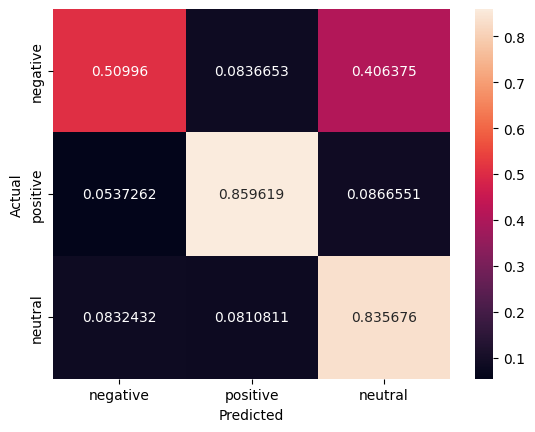

In [ ]:
# create function for plotting confusion matrix
def plot_cm(cm):
  classes = ['negative','positive','neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

cm = confusion_matrix(split['test']['label'],predictions, normalize = 'true')
plot_cm(cm)